## Rainfall Prediction

In [369]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

In [370]:
data = pd.read_csv('Rainfall.csv')
data.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,yes,9.3,80.0,26.3
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,yes,0.6,50.0,15.3
2,3,1019.7,20.3,19.3,18.0,18.4,95,91,yes,0.0,40.0,14.2
3,4,1018.9,22.3,20.6,19.1,18.8,90,88,yes,1.0,50.0,16.9
4,5,1015.9,21.3,20.7,20.2,19.9,95,81,yes,0.0,40.0,13.7


In [371]:
data.shape  

(366, 12)

In [372]:
data["day"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [373]:
print("Data Info: \n", data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   day                     366 non-null    int64  
 1   pressure                366 non-null    float64
 2   maxtemp                 366 non-null    float64
 3   temparature             366 non-null    float64
 4   mintemp                 366 non-null    float64
 5   dewpoint                366 non-null    float64
 6   humidity                366 non-null    int64  
 7   cloud                   366 non-null    int64  
 8   rainfall                366 non-null    object 
 9   sunshine                366 non-null    float64
 10           winddirection  365 non-null    float64
 11  windspeed               365 non-null    float64
dtypes: float64(8), int64(3), object(1)
memory usage: 34.4+ KB
Data Info: 
 None


In [374]:
#remove extra spaces from column names
data.columns = data.columns.str.strip()

In [375]:
data.columns   

Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'rainfall', 'sunshine', 'winddirection',
       'windspeed'],
      dtype='object')

In [376]:
#remove the day column as it is not useful for prediction
data.drop("day", axis=1, inplace=True)  

In [377]:
data.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1025.9,19.9,18.3,16.8,13.1,72,49,yes,9.3,80.0,26.3
1,1022.0,21.7,18.9,17.2,15.6,81,83,yes,0.6,50.0,15.3
2,1019.7,20.3,19.3,18.0,18.4,95,91,yes,0.0,40.0,14.2
3,1018.9,22.3,20.6,19.1,18.8,90,88,yes,1.0,50.0,16.9
4,1015.9,21.3,20.7,20.2,19.9,95,81,yes,0.0,40.0,13.7


In [378]:
data.isnull().sum()

pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
rainfall         0
sunshine         0
winddirection    1
windspeed        1
dtype: int64

In [379]:
data["winddirection"].unique()

array([ 80.,  50.,  40.,  20.,  30.,  60.,  70.,  10., 200., 220., 120.,
       190., 210., 300., 240., 180., 230.,  90., 170., 150., 100., 130.,
        nan, 160., 270., 280., 250., 260., 290., 350., 110., 140.])

In [380]:
#handle missing values in winddirection column by filling with mode
data["winddirection"]=data["winddirection"].fillna(data["winddirection"].mode()[0])
#fill missing values in windspeed column with median
data["windspeed"]=data["windspeed"].fillna(data["windspeed"].median())

In [381]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pressure       366 non-null    float64
 1   maxtemp        366 non-null    float64
 2   temparature    366 non-null    float64
 3   mintemp        366 non-null    float64
 4   dewpoint       366 non-null    float64
 5   humidity       366 non-null    int64  
 6   cloud          366 non-null    int64  
 7   rainfall       366 non-null    object 
 8   sunshine       366 non-null    float64
 9   winddirection  366 non-null    float64
 10  windspeed      366 non-null    float64
dtypes: float64(8), int64(2), object(1)
memory usage: 31.6+ KB


In [382]:
data["rainfall"].value_counts()

rainfall
yes    249
no     117
Name: count, dtype: int64

In [383]:
#converting rainfall column to binary values
data["rainfall"]=data["rainfall"].map({"no":0, "yes":1})

In [384]:
data.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1025.9,19.9,18.3,16.8,13.1,72,49,1,9.3,80.0,26.3
1,1022.0,21.7,18.9,17.2,15.6,81,83,1,0.6,50.0,15.3
2,1019.7,20.3,19.3,18.0,18.4,95,91,1,0.0,40.0,14.2
3,1018.9,22.3,20.6,19.1,18.8,90,88,1,1.0,50.0,16.9
4,1015.9,21.3,20.7,20.2,19.9,95,81,1,0.0,40.0,13.7


In [385]:
#Exploratory Data Analysis
data.shape

(366, 11)

In [386]:
sns.set_style("whitegrid")

In [387]:
data.describe()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,1013.742623,26.191257,23.747268,21.894536,19.989071,80.177596,71.128415,0.680328,4.419399,101.284153,21.534153
std,6.414776,5.978343,5.632813,5.594153,5.997021,10.062470,21.798012,0.466988,3.934398,81.722827,10.056054
min,998.500000,7.100000,4.900000,3.100000,-0.400000,36.000000,0.000000,0.000000,0.000000,10.000000,4.400000
25%,1008.500000,21.200000,18.825000,17.125000,16.125000,75.000000,58.000000,0.000000,0.500000,40.000000,13.725000
50%,1013.000000,27.750000,25.450000,23.700000,21.950000,80.500000,80.000000,1.000000,3.500000,70.000000,20.500000
75%,1018.100000,31.200000,28.600000,26.575000,25.000000,87.000000,88.000000,1.000000,8.200000,190.000000,27.825000
max,1034.600000,36.300000,32.400000,30.000000,26.700000,98.000000,100.000000,1.000000,12.100000,350.000000,59.500000


In [388]:
data.columns

Index(['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity',
       'cloud', 'rainfall', 'sunshine', 'winddirection', 'windspeed'],
      dtype='object')

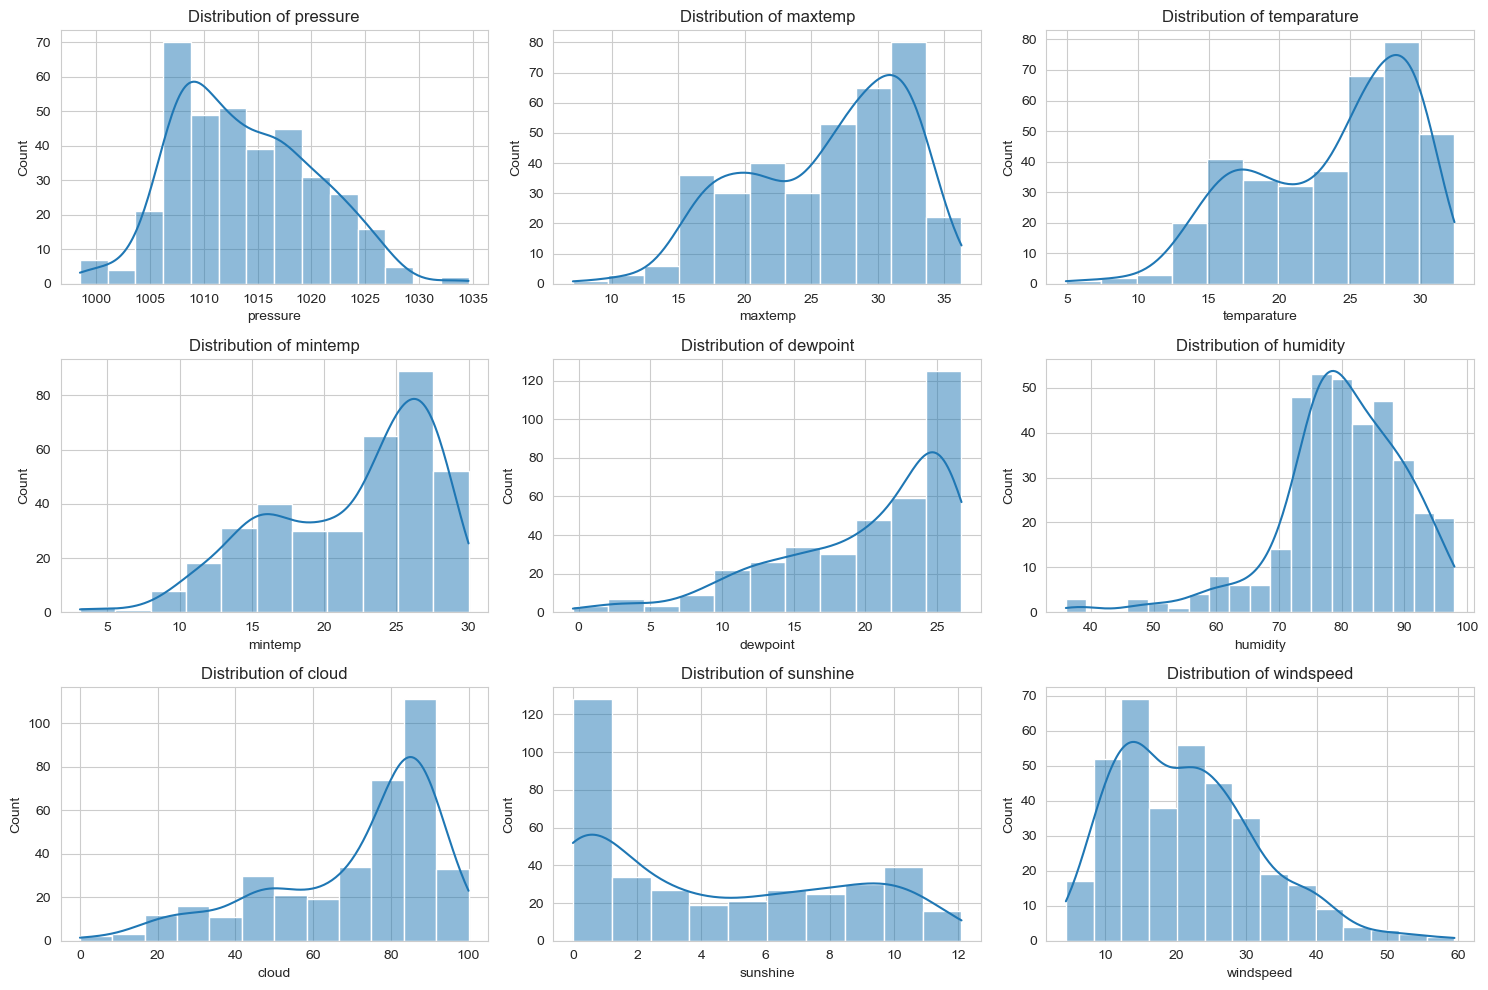

In [389]:
plt.figure(figsize=(15,10))
for i, col in enumerate(['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity',
       'cloud','sunshine', 'windspeed'],1):
    plt.subplot(3,3,i)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Count')

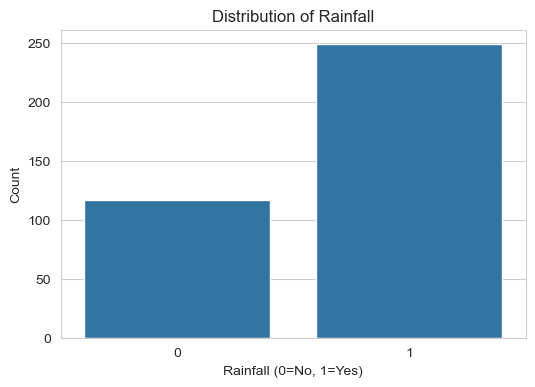

In [390]:
plt.figure(figsize=(6,4))
sns.countplot(x="rainfall", data=data)
plt.title("Distribution of Rainfall")
plt.xlabel("Rainfall (0=No, 1=Yes)")
plt.ylabel("Count")

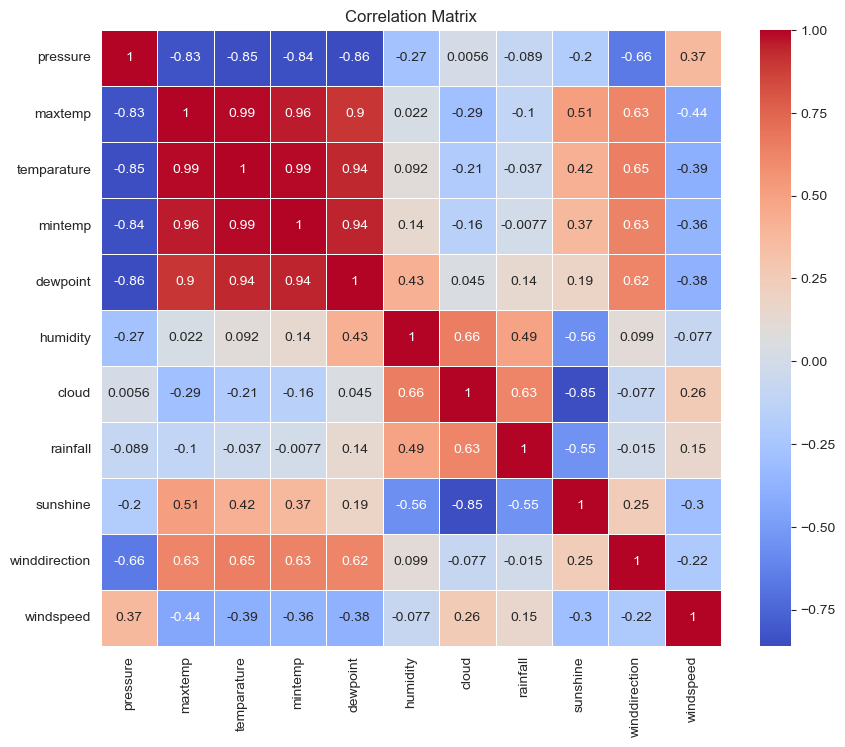

In [391]:
#correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

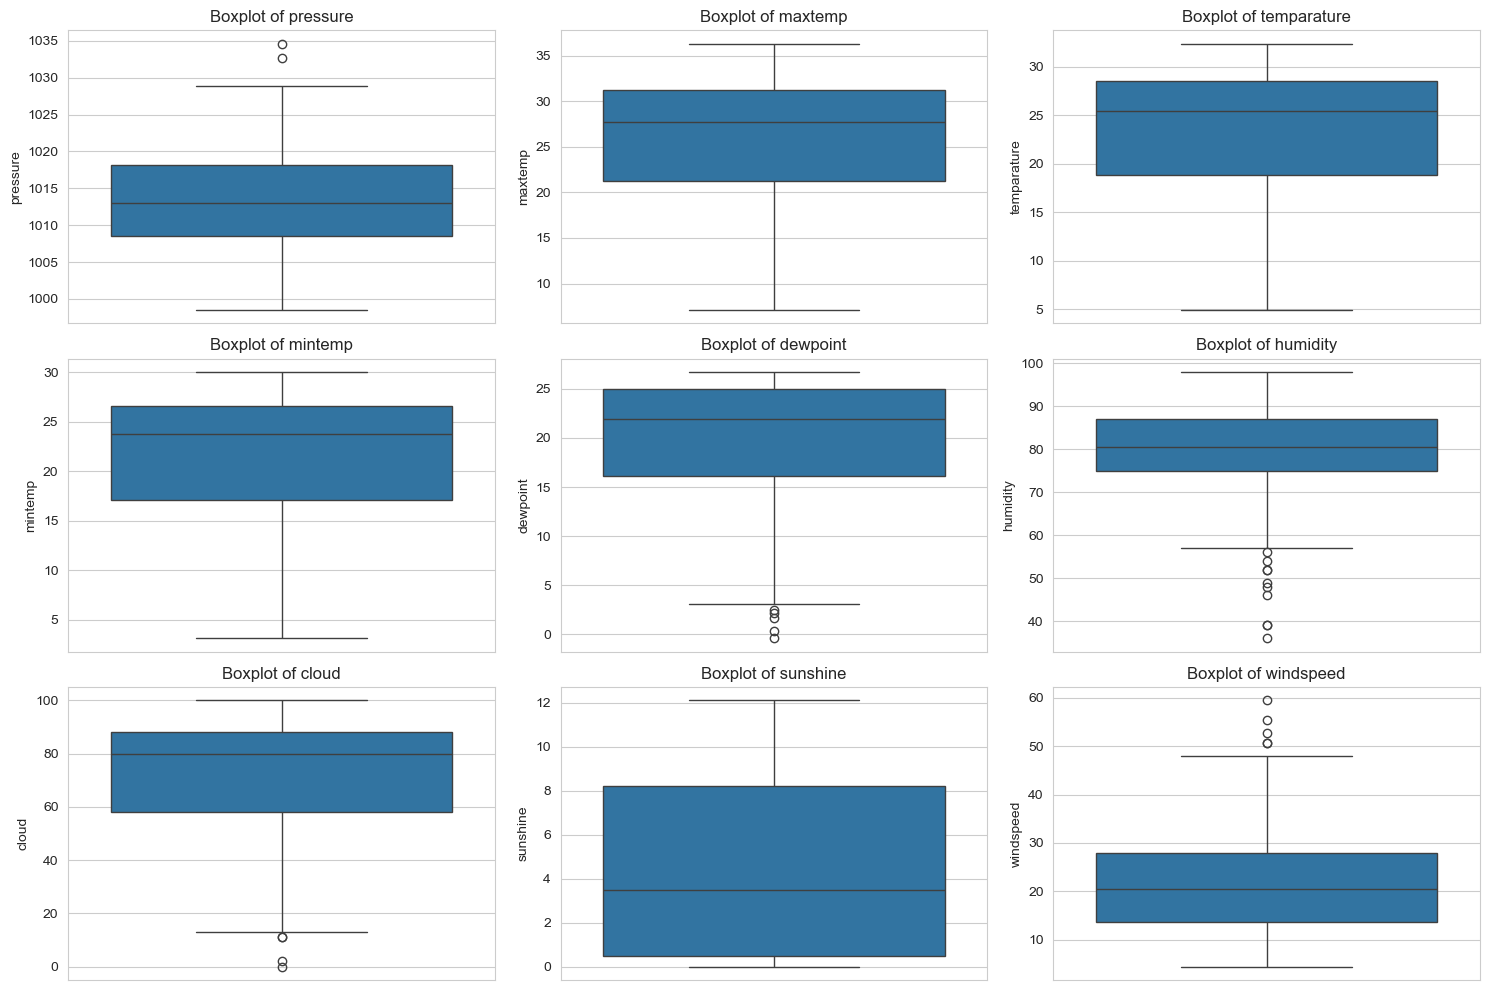

In [392]:
plt.figure(figsize=(15,10))
for i, col in enumerate(['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity',
       'cloud','sunshine', 'windspeed'],1):
    plt.subplot(3,3,i)
    sns.boxplot(data[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

Data Processing

In [393]:
data=data.drop(columns=['maxtemp', 'temparature', 'mintemp'])

In [394]:
data.head()

,pressure,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1025.9,13.1,72,49,1,9.3,80.0,26.3
1,1022.0,15.6,81,83,1,0.6,50.0,15.3
2,1019.7,18.4,95,91,1,0.0,40.0,14.2
3,1018.9,18.8,90,88,1,1.0,50.0,16.9
4,1015.9,19.9,95,81,1,0.0,40.0,13.7


In [395]:
data["rainfall"].value_counts()

rainfall
1    249
0    117
Name: count, dtype: int64

In [396]:
#seperate majority and minority classes
df_majority=data[data['rainfall']==1]
df_minority=data[data['rainfall']==0]

In [397]:
print(df_majority.shape)
print(df_minority.shape)

(249, 8)
(117, 8)


In [398]:
#downsample majority class to match minority class
df_majority_downsampled=resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)

In [399]:
df_majority_downsampled.shape

(117, 8)

In [400]:
#concatenate downsampled majority class with minority class
df_downsampled=pd.concat([df_majority_downsampled, df_minority])

In [401]:
df_downsampled.head()

,pressure,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
188,1005.9,25.6,77,53,1,10.5,270.0,11.3
9,1017.5,15.5,85,91,1,0.0,70.0,37.7
137,1012.3,20.1,80,86,1,0.3,80.0,39.5
89,1018.3,16.3,79,89,1,2.4,40.0,14.8
157,1008.8,24.7,91,80,1,2.2,20.0,11.2


In [402]:
#shudfle the dataset
df_downsampled=df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)


In [403]:
df_downsampled.head()

,pressure,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1022.2,14.1,78,90,1,0.0,30.0,28.5
1,1013.4,19.5,69,17,0,10.5,70.0,12.4
2,1006.1,24.4,74,27,0,10.8,220.0,8.7
3,1007.6,24.8,85,84,1,1.8,70.0,34.8
4,1021.2,8.4,66,18,0,10.1,20.0,24.4


In [404]:
df_downsampled["rainfall"].value_counts()

rainfall
1    117
0    117
Name: count, dtype: int64

In [405]:
#train test split
X=df_downsampled.drop(columns=["rainfall"])
y=df_downsampled["rainfall"]

In [406]:
print(X)

     pressure  dewpoint  humidity  cloud  sunshine  winddirection  windspeed
0      1022.2      14.1        78     90       0.0           30.0       28.5
1      1013.4      19.5        69     17      10.5           70.0       12.4
2      1006.1      24.4        74     27      10.8          220.0        8.7
3      1007.6      24.8        85     84       1.8           70.0       34.8
4      1021.2       8.4        66     18      10.1           20.0       24.4
..        ...       ...       ...    ...       ...            ...        ...
229    1008.1      25.4        86     75       5.7           20.0        9.5
230    1010.1      19.9        91     89       0.0           70.0       31.8
231    1020.6      14.7        91     88       0.3           50.0       24.4
232    1008.3      24.1        74     29       5.7           10.0        4.4
233    1005.0      26.1        87     82       2.2          160.0       12.6

[234 rows x 7 columns]


In [407]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model Training

In [408]:
rf_model=RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50,100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [409]:
#hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,50


In [410]:
best_rf_model = grid_search.best_estimator_
print("Best Hyperparameters: ", grid_search.best_params_)


Best Hyperparameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}


Model Evaluation

In [411]:
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5)
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: ", np.mean(cv_scores))

Cross-validation scores:  [0.68421053 0.81578947 0.83783784 0.83783784 0.91891892]
Mean cross-validation score:  0.818918918918919


In [412]:
#test set performance
y_pred = best_rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test, y_pred))   


Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.71      0.74        24
           1       0.72      0.78      0.75        23

    accuracy                           0.74        47
   macro avg       0.75      0.75      0.74        47
weighted avg       0.75      0.74      0.74        47

Confusion Matrix:
 [[17  7]
 [ 5 18]]
Accuracy Score:  0.7446808510638298


Prediction on unknown data

In [413]:
input_data = np.array([[1015.9, 19.9, 95, 81, 0.0, 40, 13.7]])
input_df=pd.DataFrame(input_data, columns=['pressure', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed'])
 


In [415]:
input_df

,pressure,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,1015.9,19.9,95.0,81.0,0.0,40.0,13.7


In [416]:
prediction = best_rf_model.predict(input_df)
print("Predicted Result:", "Rainfall" if prediction[0]==1 else "No Rainfall") 

Predicted Result: Rainfall


In [417]:
#save model and feature names to a pickle file
model_data = {
    "model": best_rf_model,
    "features": X.columns.tolist()
}
with open("rainfall_model.pkl", "wb") as f:
    pickle.dump(model_data, f)

Load the saved file and use it

In [419]:
import pickle
import pandas as pd

In [420]:
model=model_data["model"]
feature_names=model_data["features"]  
  

In [421]:
input_data = np.array([[1015.9, 19.9, 95, 81, 0.0, 40, 13.7]])
input_df=pd.DataFrame(input_data, columns=feature_names)

In [422]:
prediction = best_rf_model.predict(input_df)
print("Predicted Result:", "Rainfall" if prediction[0]==1 else "No Rainfall") 

Predicted Result: Rainfall
